# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/assignment3"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/CS444/assignment3_starter_sp24" $datadir # TODO: Fill your Assignment 3 path
os.chdir(datadir)
!pwd

/content/drive/My Drive/CS444/assignment3_starter_sp24


#Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__getitem__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img

    # TODO: Implement rotate_img() - return the rotated img
    elif rot == 1 or rot == 2 or rot == 3:
        return transforms.functional.rotate(img=img, angle=rot*90)

    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(len(trainset))
print(len(testset))

50000
10000


### Show some example images and rotated images with labels:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


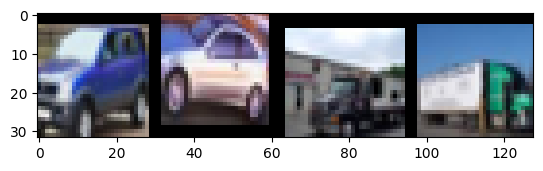

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class labels:  car   car   truck truck


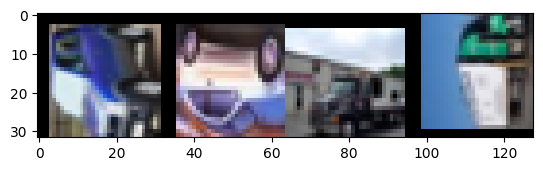

Rotation labels:  90    180   0     90   


In [ ]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')

def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [ ]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs = net(images)
            predicted = torch.argmax(outputs, dim=1)

            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)

            # calculate accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task

### In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [ ]:
import torch.optim as optim

# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = "Adam"


In [ ]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    if optimizer == "Adam":
        optimizer_use = optim.Adam(net.parameters(), lr=init_lr, eps=1e-08, weight_decay=0.001)
    elif optimizer == "SGD":
        optimizer_use = optim.SGD(net.parameters(), lr=init_lr, momentum=0.01)

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer_use.zero_grad()

            # TODO: forward + backward + optimize
            y_pred = net(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer_use.step()

            # TODO: Get predicted results
            predicted = torch.argmax(y_pred, dim=1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        adjust_learning_rate(optimizer_use, epoch, init_lr, decay_epochs=decay_epochs)

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        with torch.no_grad():
          run_test(net, testloader, criterion, task)

    print('Finished Training')

In [ ]:
train(net, criterion, optimizer, num_epochs=50, decay_epochs=15, init_lr=0.001, task='rotation')

# TODO: Save the model
torch.save(net.state_dict(), './net_pretrain.pth')

[1,   100] loss: 1.270 acc: 43.27 time: 2.56
[1,   200] loss: 1.130 acc: 50.38 time: 2.58
[1,   300] loss: 1.112 acc: 52.43 time: 2.45
TESTING:
Accuracy of the network on the 10000 test images: 55.10 %
Average loss on the 10000 test images: 1.044
[2,   100] loss: 1.066 acc: 54.20 time: 2.55
[2,   200] loss: 1.037 acc: 55.68 time: 2.57
[2,   300] loss: 1.040 acc: 55.95 time: 2.44
TESTING:
Accuracy of the network on the 10000 test images: 58.21 %
Average loss on the 10000 test images: 0.985
[3,   100] loss: 1.002 acc: 57.59 time: 2.53
[3,   200] loss: 0.980 acc: 59.20 time: 2.54
[3,   300] loss: 0.974 acc: 59.08 time: 2.42
TESTING:
Accuracy of the network on the 10000 test images: 57.12 %
Average loss on the 10000 test images: 1.002
[4,   100] loss: 0.957 acc: 60.01 time: 2.56
[4,   200] loss: 0.960 acc: 60.00 time: 2.69
[4,   300] loss: 0.943 acc: 60.68 time: 2.46
TESTING:
Accuracy of the network on the 10000 test images: 60.72 %
Average loss on the 10000 test images: 0.943
[5,   100] l

# Fine-tuning on the pre-trained model
### In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

import torch.optim as optim

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# TODO: Load the pre-trained ResNet18 model
net = resnet18(num_classes=10).to(device)
net.load_state_dict(torch.load('./net_pretrain.pt'))
# net.train()
# net = torch.load('net_pretrain.pt', map_location=torch.device(device))
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable

## unfreeze layer4 and fc
for name, param in net.named_parameters():
    if "layer4" in name:
        param.requires_grad = True
    elif "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = "Adam"

In [ ]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    if optimizer == "Adam":
        optimizer_use = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=init_lr, eps=1e-08, weight_decay=0.001)
    elif optimizer == "SGD":
        optimizer_use = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=init_lr, momentum=0.01)

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer_use.zero_grad()

            # TODO: forward + backward + optimize
            y_pred = net(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer_use.step()

            # TODO: Get predicted results
            predicted = torch.argmax(y_pred, dim=1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        adjust_learning_rate(optimizer_use, epoch, init_lr, decay_epochs=decay_epochs)

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        with torch.no_grad():
          run_test(net, testloader, criterion, task)

    print('Finished Training')

In [ ]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.001, task='classification')
torch.save(net, 'finetune_pretrain.pt')

[1,   100] loss: 1.655 acc: 40.69 time: 2.71
[1,   200] loss: 1.302 acc: 52.20 time: 2.56
[1,   300] loss: 1.201 acc: 56.54 time: 2.55
TESTING:
Accuracy of the network on the 10000 test images: 59.82 %
Average loss on the 10000 test images: 1.133
[2,   100] loss: 1.142 acc: 58.98 time: 2.69
[2,   200] loss: 1.124 acc: 59.98 time: 2.58
[2,   300] loss: 1.112 acc: 59.71 time: 2.54
TESTING:
Accuracy of the network on the 10000 test images: 61.35 %
Average loss on the 10000 test images: 1.106
[3,   100] loss: 1.089 acc: 61.25 time: 2.65
[3,   200] loss: 1.081 acc: 61.72 time: 2.52
[3,   300] loss: 1.057 acc: 62.12 time: 2.52
TESTING:
Accuracy of the network on the 10000 test images: 63.07 %
Average loss on the 10000 test images: 1.043
[4,   100] loss: 1.043 acc: 62.61 time: 2.70
[4,   200] loss: 1.048 acc: 62.52 time: 2.54
[4,   300] loss: 1.047 acc: 62.92 time: 2.55
TESTING:
Accuracy of the network on the 10000 test images: 64.18 %
Average loss on the 10000 test images: 1.021
[5,   100] l

# Fine-tuning on the randomly initialized model
### In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(num_classes=10)
net = net.to(device)

In [ ]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable

## change last layer to have 10 output features
net.fc = nn.Linear(in_features=512, out_features=10, bias=True).to(device)
nn.init.normal_(net.fc.weight)

## unfreeze layer4 and fc
net.eval()
for name, param in net.named_parameters():
    param.requires_grad = False
    if "layer4" in name:
        param.requires_grad = True
    elif "fc" in name:
        param.requires_grad = True

print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = "Adam"

In [ ]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    if optimizer == "Adam":
        optimizer_use = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=init_lr, eps=1e-08, weight_decay=0.001)
    elif optimizer == "SGD":
        optimizer_use = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=init_lr, momentum=0.01)

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer_use.zero_grad()

            # TODO: forward + backward + optimize
            y_pred = net(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer_use.step()

            # TODO: Get predicted results
            predicted = torch.argmax(y_pred, dim=1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # adjust_learning_rate(optimizer_use, epoch, init_lr, decay_epochs=decay_epochs)

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        with torch.no_grad():
          run_test(net, testloader, criterion, task)

    print('Finished Training')

In [ ]:
train(net, criterion, optimizer, num_epochs=30, decay_epochs=10, init_lr=0.001, task='classification')
torch.save(net, 'finetune_random.pt')

[1,   100] loss: 6.794 acc: 16.42 time: 2.66
[1,   200] loss: 2.441 acc: 22.82 time: 2.58
[1,   300] loss: 2.242 acc: 25.57 time: 2.54
TESTING:
Accuracy of the network on the 10000 test images: 32.59 %
Average loss on the 10000 test images: 1.968
[2,   100] loss: 2.070 acc: 29.17 time: 2.72
[2,   200] loss: 2.005 acc: 30.40 time: 2.57
[2,   300] loss: 1.970 acc: 30.75 time: 2.54
TESTING:
Accuracy of the network on the 10000 test images: 32.58 %
Average loss on the 10000 test images: 1.896
[3,   100] loss: 1.907 acc: 32.06 time: 2.71
[3,   200] loss: 1.886 acc: 33.33 time: 2.57
[3,   300] loss: 1.898 acc: 32.41 time: 2.55
TESTING:
Accuracy of the network on the 10000 test images: 36.73 %
Average loss on the 10000 test images: 1.749
[4,   100] loss: 1.880 acc: 33.17 time: 2.67
[4,   200] loss: 1.839 acc: 34.17 time: 2.57
[4,   300] loss: 1.817 acc: 34.26 time: 2.55
TESTING:
Accuracy of the network on the 10000 test images: 35.93 %
Average loss on the 10000 test images: 1.783
[5,   100] l

# Supervised training on the pre-trained model
### In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [ ]:
# TODO: Load the pre-trained ResNet18 model
import torch.nn as nn
import torch.nn.functional as F

# TODO: Load the pre-trained ResNet18 model
net = resnet18(num_classes=10).to(device)
net.load_state_dict(torch.load('./net_pretrain.pt'))
# net.train()
# net = torch.load('net_pretrain.pt', map_location=torch.device(device))
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = "Adam"

In [ ]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    if optimizer == "Adam":
        optimizer_use = optim.Adam(net.parameters(), lr=init_lr, eps=1e-08, weight_decay=0.001)
    elif optimizer == "SGD":
        optimizer_use = optim.SGD(net.parameters(), lr=init_lr, momentum=0.01)

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer_use.zero_grad()

            # TODO: forward + backward + optimize
            y_pred = net(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer_use.step()

            # TODO: Get predicted results
            predicted = torch.argmax(y_pred, dim=1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        adjust_learning_rate(optimizer_use, epoch, init_lr, decay_epochs=decay_epochs)

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        with torch.no_grad():
          run_test(net, testloader, criterion, task)

    print('Finished Training')

In [ ]:
train(net, criterion, optimizer, num_epochs=50, decay_epochs=10, init_lr=0.001, task='classification')
torch.save(net, 'supervised_pretrain.pt')

[1,   100] loss: 1.562 acc: 44.13 time: 3.01
[1,   200] loss: 1.149 acc: 59.60 time: 2.55
[1,   300] loss: 1.045 acc: 63.06 time: 2.55
TESTING:
Accuracy of the network on the 10000 test images: 65.70 %
Average loss on the 10000 test images: 0.983
[2,   100] loss: 0.946 acc: 67.09 time: 2.68
[2,   200] loss: 0.904 acc: 68.80 time: 2.57
[2,   300] loss: 0.886 acc: 68.88 time: 2.56
TESTING:
Accuracy of the network on the 10000 test images: 71.49 %
Average loss on the 10000 test images: 0.821
[3,   100] loss: 0.810 acc: 72.14 time: 2.70
[3,   200] loss: 0.830 acc: 71.13 time: 2.57
[3,   300] loss: 0.796 acc: 72.77 time: 2.54
TESTING:
Accuracy of the network on the 10000 test images: 72.31 %
Average loss on the 10000 test images: 0.791
[4,   100] loss: 0.752 acc: 73.84 time: 2.70
[4,   200] loss: 0.766 acc: 73.93 time: 2.56
[4,   300] loss: 0.761 acc: 74.24 time: 2.56
TESTING:
Accuracy of the network on the 10000 test images: 73.88 %
Average loss on the 10000 test images: 0.762
[5,   100] l

# Supervised training on the randomly initialized model
### In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(num_classes=10)
net = net.to(device)

In [ ]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = "Adam"

In [ ]:
train(net, criterion, optimizer, num_epochs=50, decay_epochs=10, init_lr=0.001, task='classification')
torch.save(net, 'supervised_random.pt')

[1,   100] loss: 1.822 acc: 34.18 time: 2.67
[1,   200] loss: 1.541 acc: 43.57 time: 2.56
[1,   300] loss: 1.424 acc: 48.12 time: 2.56
TESTING:
Accuracy of the network on the 10000 test images: 51.97 %
Average loss on the 10000 test images: 1.367
[2,   100] loss: 1.277 acc: 54.01 time: 2.72
[2,   200] loss: 1.223 acc: 55.75 time: 2.59
[2,   300] loss: 1.161 acc: 58.88 time: 2.54
TESTING:
Accuracy of the network on the 10000 test images: 60.86 %
Average loss on the 10000 test images: 1.121
[3,   100] loss: 1.082 acc: 61.77 time: 2.68
[3,   200] loss: 1.062 acc: 61.93 time: 2.57
[3,   300] loss: 1.022 acc: 64.25 time: 2.56
TESTING:
Accuracy of the network on the 10000 test images: 65.35 %
Average loss on the 10000 test images: 1.014
[4,   100] loss: 0.976 acc: 65.62 time: 2.71
[4,   200] loss: 0.965 acc: 66.80 time: 2.56
[4,   300] loss: 0.961 acc: 66.57 time: 2.56
TESTING:
Accuracy of the network on the 10000 test images: 64.19 %
Average loss on the 10000 test images: 1.051
[5,   100] l

# Extra Credit 1: Accuracy-Sample Plot

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import resnet18
import time

criterion = nn.CrossEntropyLoss()
optimizer = "Adam"

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs = net(images)
            predicted = torch.argmax(outputs, dim=1)

            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)

            # calculate accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

    return 100 * correct / total

In [ ]:
def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    test_acc_max = 0

    if optimizer == "Adam":
        optimizer_use = optim.Adam(net.parameters(), lr=init_lr, eps=1e-08, weight_decay=0.001)
    elif optimizer == "SGD":
        optimizer_use = optim.SGD(net.parameters(), lr=init_lr, momentum=0.01)

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
                images, labels = imgs_rotated.to(device), rotation_label.to(device)

            elif task == 'classification':
                images, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer_use.zero_grad()

            # TODO: forward + backward + optimize
            y_pred = net(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer_use.step()

            # TODO: Get predicted results
            predicted = torch.argmax(y_pred, dim=1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        adjust_learning_rate(optimizer_use, epoch, init_lr, decay_epochs=decay_epochs)

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        with torch.no_grad():
            test_acc = run_test(net, testloader, criterion, task)
            if test_acc > test_acc_max:
                test_acc_max = test_acc

    print('Finished Training')
    return test_acc_max

In [ ]:
### Stage 1: Pretrain + Finetune
data_num = [20, 100, 400, 1000, 5000]
accuracy = []

for num in data_num:
    ## Load Pretrain Model
    net = resnet18(num_classes=10).to(device)
    net.load_state_dict(torch.load('./net_pretrain.pt'))

    ## unfreeze layer4 and fc
    for name, param in net.named_parameters():
        if "layer4" in name:
            param.requires_grad = True
        elif "fc" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    ## mini-trainset
    mini_set = []
    sample_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
    idx = 0
    while sum(list(sample_dict.values())) < num * 10:
        temp = trainset[idx]
        if sample_dict[int(temp[3])] >= num:               # class already full
            idx += 1
        else:
            mini_set.append(temp)
            idx += 1
            sample_dict[int(temp[3])] += 1

    ## make dataloader
    trainloader = torch.utils.data.DataLoader(mini_set, batch_size=min(len(mini_set), batch_size), shuffle=True, num_workers=2)

    print("\nStart Finetuning with {} samples perclass.".format(num))
    test_acc_max = train(net, criterion, optimizer, num_epochs=50, decay_epochs=10, init_lr=0.001, task='classification')
    torch.save(net, 'finetune_pretrain_{}.pt'.format(num))
    accuracy.append(test_acc_max)

print(accuracy)


Start Finetuning with 20 samples.
TESTING:
Accuracy of the network on the 10000 test images: 11.48 %
Average loss on the 10000 test images: 2.524
TESTING:
Accuracy of the network on the 10000 test images: 12.10 %
Average loss on the 10000 test images: 2.447
TESTING:
Accuracy of the network on the 10000 test images: 12.80 %
Average loss on the 10000 test images: 2.378
TESTING:
Accuracy of the network on the 10000 test images: 13.56 %
Average loss on the 10000 test images: 2.316
TESTING:
Accuracy of the network on the 10000 test images: 14.36 %
Average loss on the 10000 test images: 2.259
TESTING:
Accuracy of the network on the 10000 test images: 15.50 %
Average loss on the 10000 test images: 2.210
TESTING:
Accuracy of the network on the 10000 test images: 16.65 %
Average loss on the 10000 test images: 2.167
TESTING:
Accuracy of the network on the 10000 test images: 17.98 %
Average loss on the 10000 test images: 2.133
TESTING:
Accuracy of the network on the 10000 test images: 19.32 %
Av

In [ ]:
### Stage 2: Supervised Training
data_num = [20, 100, 400, 1000, 5000]
accuracy_st = []

for num in data_num:
    ## Load resnet Model
    net = resnet18(num_classes=10).to(device)
    net.train()

    ## mini-trainset
    mini_set = []
    sample_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
    idx = 0
    while sum(list(sample_dict.values())) < num:
        temp = trainset[idx]
        if sample_dict[int(temp[3])] >= num / 10:               # class already full
            idx += 1
        else:
            mini_set.append(temp)
            idx += 1
            sample_dict[int(temp[3])] += 1

    ## make dataloader
    trainloader = torch.utils.data.DataLoader(mini_set, batch_size=min(len(mini_set), batch_size), shuffle=True, num_workers=2)

    print("\nStart Finetuning with {} samples perclass.".format(num))
    test_acc_max = train(net, criterion, optimizer, num_epochs=50, decay_epochs=10, init_lr=0.001, task='classification')
    torch.save(net, 'finetune_pretrain_{}.pt'.format(num))
    accuracy_st.append(test_acc_max)

print(accuracy_st)


Start Finetuning with 20 samples perclass.
TESTING:
Accuracy of the network on the 10000 test images: 14.72 %
Average loss on the 10000 test images: 2.426
TESTING:
Accuracy of the network on the 10000 test images: 16.24 %
Average loss on the 10000 test images: 2.524
TESTING:
Accuracy of the network on the 10000 test images: 16.57 %
Average loss on the 10000 test images: 2.712
TESTING:
Accuracy of the network on the 10000 test images: 16.28 %
Average loss on the 10000 test images: 2.912
TESTING:
Accuracy of the network on the 10000 test images: 16.43 %
Average loss on the 10000 test images: 3.097
TESTING:
Accuracy of the network on the 10000 test images: 16.44 %
Average loss on the 10000 test images: 3.261
TESTING:
Accuracy of the network on the 10000 test images: 16.31 %
Average loss on the 10000 test images: 3.408
TESTING:
Accuracy of the network on the 10000 test images: 16.13 %
Average loss on the 10000 test images: 3.539
TESTING:
Accuracy of the network on the 10000 test images: 1

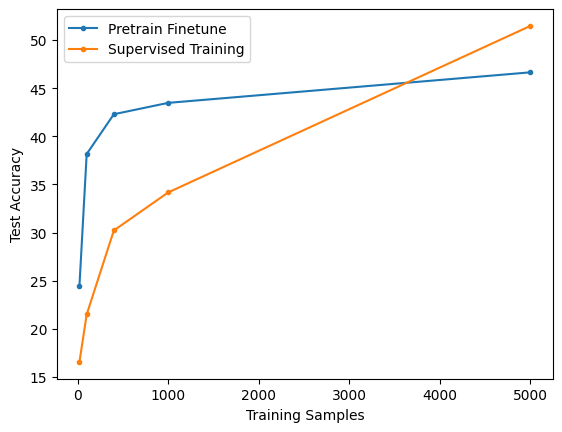

In [ ]:
### Plot Result
import matplotlib.pyplot as plt

plt.xlabel('Training Samples')
plt.ylabel('Test Accuracy')
plt.plot(data_num, accuracy, marker='o', markersize=3)
plt.plot(data_num, accuracy_st, marker='o', markersize=3)
plt.legend(["Pretrain Finetune", "Supervised Training"])
plt.show()

# Extra Credit 2: More Advanced Model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
### Load Model for Pretrain

import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet50

net = resnet50(num_classes=4)
net = net.to(device)

In [ ]:
import torch.optim as optim

# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = "Adam"

In [ ]:
def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    if optimizer == "Adam":
        optimizer_use = optim.Adam(net.parameters(), lr=init_lr, eps=1e-08, weight_decay=0.001)
    elif optimizer == "SGD":
        optimizer_use = optim.SGD(net.parameters(), lr=init_lr, momentum=0.01)

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer_use.zero_grad()

            # TODO: forward + backward + optimize
            y_pred = net(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer_use.step()

            # TODO: Get predicted results
            predicted = torch.argmax(y_pred, dim=1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        adjust_learning_rate(optimizer_use, epoch, init_lr, decay_epochs=decay_epochs)

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        with torch.no_grad():
          run_test(net, testloader, criterion, task)

    print('Finished Training')

In [ ]:
### Pretrain
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.001, task='rotation')

# Save the model
torch.save(net.state_dict(), './net_pretrain.pth')

[1,   100] loss: 1.517 acc: 32.38 time: 2.82
[1,   200] loss: 1.284 acc: 42.85 time: 2.64
[1,   300] loss: 1.249 acc: 46.69 time: 2.59
TESTING:
Accuracy of the network on the 10000 test images: 49.98 %
Average loss on the 10000 test images: 1.124
[2,   100] loss: 1.148 acc: 50.00 time: 2.87
[2,   200] loss: 1.119 acc: 51.00 time: 2.65
[2,   300] loss: 1.106 acc: 52.80 time: 2.64
TESTING:
Accuracy of the network on the 10000 test images: 53.91 %
Average loss on the 10000 test images: 1.070
[3,   100] loss: 1.073 acc: 53.73 time: 2.82
[3,   200] loss: 1.055 acc: 54.45 time: 2.65
[3,   300] loss: 1.065 acc: 54.20 time: 2.66
TESTING:
Accuracy of the network on the 10000 test images: 55.37 %
Average loss on the 10000 test images: 1.039
[4,   100] loss: 1.040 acc: 55.13 time: 2.84
[4,   200] loss: 1.028 acc: 56.00 time: 2.67
[4,   300] loss: 1.009 acc: 56.92 time: 2.65
TESTING:
Accuracy of the network on the 10000 test images: 58.13 %
Average loss on the 10000 test images: 0.981
[5,   100] l

In [ ]:
### Load Model for Finetune
net = resnet50(num_classes=4).to(device)
net.load_state_dict(torch.load('./net_pretrain.pth'))
net.fc = nn.Linear(in_features=2048, out_features=10, bias=True).to(device)
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
## unfreeze layer4 and fc
for name, param in net.named_parameters():
    if "layer4" in name:
        param.requires_grad = True
    elif "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.conv3.weight
	 layer4.0.bn3.weight
	 layer4.0.bn3.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 layer4.1.conv3.weight
	 layer4.1.bn3.weight
	 layer4.1.bn3.bias
	 layer4.2.conv1.weight
	 layer4.2.bn1.weight
	 layer4.2.bn1.bias
	 layer4.2.conv2.weight
	 layer4.2.bn2.weight
	 layer4.2.bn2.bias
	 layer4.2.conv3.weight
	 layer4.2.bn3.weight
	 layer4.2.bn3.bias
	 fc.weight
	 fc.bias


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = "Adam"

In [ ]:
### Finetune
def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    if optimizer == "Adam":
        optimizer_use = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=init_lr, eps=1e-08, weight_decay=0.001)
    elif optimizer == "SGD":
        optimizer_use = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=init_lr, momentum=0.01)

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer_use.zero_grad()

            # TODO: forward + backward + optimize
            y_pred = net(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer_use.step()

            # TODO: Get predicted results
            predicted = torch.argmax(y_pred, dim=1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        adjust_learning_rate(optimizer_use, epoch, init_lr, decay_epochs=decay_epochs)

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        with torch.no_grad():
          run_test(net, testloader, criterion, task)

    print('Finished Training')

In [ ]:
train(net, criterion, optimizer, num_epochs=30, decay_epochs=10, init_lr=0.001, task='classification')
torch.save(net, 'finetune_pretrain.pt')

[1,   100] loss: 1.598 acc: 41.88 time: 2.81
[1,   200] loss: 1.215 acc: 55.23 time: 2.67
[1,   300] loss: 1.124 acc: 59.83 time: 2.63
TESTING:
Accuracy of the network on the 10000 test images: 61.79 %
Average loss on the 10000 test images: 1.064
[2,   100] loss: 1.027 acc: 62.80 time: 2.78
[2,   200] loss: 1.001 acc: 64.54 time: 2.70
[2,   300] loss: 0.967 acc: 65.66 time: 2.63
TESTING:
Accuracy of the network on the 10000 test images: 64.80 %
Average loss on the 10000 test images: 0.984
[3,   100] loss: 0.927 acc: 67.65 time: 2.80
[3,   200] loss: 0.931 acc: 67.14 time: 2.69
[3,   300] loss: 0.917 acc: 68.09 time: 2.62
TESTING:
Accuracy of the network on the 10000 test images: 68.12 %
Average loss on the 10000 test images: 0.940
[4,   100] loss: 0.881 acc: 68.95 time: 2.79
[4,   200] loss: 0.878 acc: 69.05 time: 2.70
[4,   300] loss: 0.859 acc: 69.84 time: 2.64
TESTING:
Accuracy of the network on the 10000 test images: 67.80 %
Average loss on the 10000 test images: 0.920
[5,   100] l

# Extra Credit 3: Rotation Prediction Model on Larger Dataset

### Load Dataset

In [ ]:
from fastai.vision.all import *
from fastai.collab import *

path = untar_data(URLs.IMAGENETTE_160)
trainset = path/"train"
testset = path/"val"

In [ ]:
print(trainset)
print(testset)

/u/qilong/.fastai/data/imagenette2-160/train
/u/qilong/.fastai/data/imagenette2-160/val


In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=16),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 256

def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs = net(images)
            predicted = torch.argmax(outputs, dim=1)

            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)

            # calculate accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('TESTING:')
    print(f'Accuracy of the network on the {len(testloader)} test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the {len(testloader)} test images: {avg_test_loss:.3f}')

In [ ]:
# test CSV
df = pd.read_csv('noisy_imagenette.csv')
print(len(df[df["is_valid"] == False]))

9469


In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torchvision.datasets import VisionDataset
from torchvision import transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = "Adam"

def create_class_to_idx(root_dir):
    classes = [d.name for d in os.scandir(root_dir) if d.is_dir()]
    classes.sort()
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}
    return class_to_idx

class ImageNetteRotation(VisionDataset):
    def __init__(self, root, csv_file, split, class_to_idx,transform=None, target_transform=None, download=False):
        super(ImageNetteRotation, self).__init__(root, transform=transform,
                                                  target_transform=target_transform)
        self.images_df = pd.read_csv(csv_file)
        if split == "train":
            self.images_df = self.images_df[self.images_df['is_valid'] == False]
        elif split == "val":
            self.images_df = self.images_df[self.images_df['is_valid'] == True]
        else:
            print("Invalid Split!")
            return
        self.root = root
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.images_df)

    def __getitem__(self, index):
        img_path = self.images_df.iloc[index, 0]
        img_path = os.path.join(self.root, img_path)

        image = Image.open(img_path).convert("RGB")
        cls_name = self.images_df.iloc[index, 1]
        cls_label = self.class_to_idx[cls_name]

        rotation = int(np.random.choice([0, 90, 180, 270]))
        rot_image = transforms.functional.rotate(image, rotation)
        rot_label = rotation // 90
        if self.transform is not None:
            transformed_image = self.transform(image)
            rot_image = self.transform(rot_image)

        return transformed_image, rot_image, rot_label, torch.tensor(cls_label).long()

dataset_root = path
csv_file = 'noisy_imagenette.csv'

# train_dir = os.path.join(dataset_root, 'train')
# test_dir = os.path.join(dataset_root, 'val')
class_to_idx = create_class_to_idx(train_dir)

# print(class_to_idx)

trainset = ImageNetteRotation(root=dataset_root,
                              csv_file=csv_file,
                              split="train",
                              class_to_idx=class_to_idx,
                              transform=transform_train,
                              download=True)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                           shuffle=True,
                                           num_workers=2)

testset = ImageNetteRotation(root=dataset_root,
                             csv_file=csv_file,
                             split="val",
                             class_to_idx=class_to_idx,
                             transform=transform_test,
                             download=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,
                                          shuffle=False,
                                          num_workers=2)


In [ ]:
print(len(train_loader))
print(len(test_loader))

148
62


### Pretrain on Rotation Task

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = "Adam"

net = resnet18(num_classes=4)
net = net.to(device)
def train_nette(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    if optimizer == "Adam":
        optimizer_use = optim.Adam(net.parameters(), lr=init_lr, eps=1e-08, weight_decay=0.001)
    elif optimizer == "SGD":
        optimizer_use = optim.SGD(net.parameters(), lr=init_lr, momentum=0.01)

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(train_loader, 0):

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer_use.zero_grad()

            # TODO: forward + backward + optimize
            y_pred = net(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer_use.step()

            # TODO: Get predicted results
            predicted = torch.argmax(y_pred, dim=1)

            # print statistics
            print_freq = 50
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        adjust_learning_rate(optimizer_use, epoch, init_lr, decay_epochs=decay_epochs)

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        with torch.no_grad():
          run_test(net, test_loader, criterion, task)

    print('Finished Training')

In [ ]:
## run cell two times (60 epochs in total)
train_nette(net, criterion, optimizer, num_epochs=30, decay_epochs=10, init_lr=0.0001, task='rotation')
torch.save(net.state_dict(), './nette_pretrain.pth')

[1,    50] loss: 0.753 acc: 57.12 time: 6.09
[1,   100] loss: 0.750 acc: 57.47 time: 5.65
TESTING:
Accuracy of the network on the 62 test images: 57.22 %
Average loss on the 62 test images: 0.777
[2,    50] loss: 0.746 acc: 58.94 time: 5.98
[2,   100] loss: 0.750 acc: 58.41 time: 5.74
TESTING:
Accuracy of the network on the 62 test images: 35.44 %
Average loss on the 62 test images: 1.808
[3,    50] loss: 0.736 acc: 57.34 time: 6.07
[3,   100] loss: 0.746 acc: 58.25 time: 5.76
TESTING:
Accuracy of the network on the 62 test images: 54.37 %
Average loss on the 62 test images: 0.853
[4,    50] loss: 0.755 acc: 57.47 time: 5.96
[4,   100] loss: 0.757 acc: 58.44 time: 5.71
TESTING:
Accuracy of the network on the 62 test images: 56.66 %
Average loss on the 62 test images: 0.894
[5,    50] loss: 0.755 acc: 58.69 time: 6.36
[5,   100] loss: 0.747 acc: 58.09 time: 5.68
TESTING:
Accuracy of the network on the 62 test images: 56.51 %
Average loss on the 62 test images: 0.774
[6,    50] loss: 0.7

### Finetune on Classification Task

In [ ]:
# Load the pre-trained ResNet18 model
net = resnet18(num_classes=4).to(device)
net.load_state_dict(torch.load('./nette_pretrain.pth'))
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
net.fc = nn.Linear(in_features=512, out_features=10, bias=True).to(device)

## unfreeze layer4 and fc
for name, param in net.named_parameters():
    if "layer4" in name:
        param.requires_grad = True
    elif "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = "Adam"

In [ ]:
def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    if optimizer == "Adam":
        optimizer_use = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=init_lr, eps=1e-08, weight_decay=0.001)
    elif optimizer == "SGD":
        optimizer_use = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=init_lr, momentum=0.01)

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer_use.zero_grad()

            # TODO: forward + backward + optimize
            y_pred = net(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer_use.step()

            # TODO: Get predicted results
            predicted = torch.argmax(y_pred, dim=1)

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        adjust_learning_rate(optimizer_use, epoch, init_lr, decay_epochs=decay_epochs)

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        with torch.no_grad():
          run_test(net, testloader, criterion, task)

    print('Finished Training')

In [ ]:
## run cell two times (40 epochs in total)
train_nette(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.0001, task='classification')
torch.save(net.state_dict(), './nette_finetune.pth')

[1,    50] loss: 0.643 acc: 79.22 time: 6.13
[1,   100] loss: 0.619 acc: 79.78 time: 5.64
TESTING:
Accuracy of the network on the 62 test images: 74.27 %
Average loss on the 62 test images: 0.811
[2,    50] loss: 0.624 acc: 79.97 time: 6.46
[2,   100] loss: 0.624 acc: 79.62 time: 6.12
TESTING:
Accuracy of the network on the 62 test images: 74.57 %
Average loss on the 62 test images: 0.807
[3,    50] loss: 0.605 acc: 80.22 time: 5.94
[3,   100] loss: 0.615 acc: 80.41 time: 5.70
TESTING:
Accuracy of the network on the 62 test images: 75.16 %
Average loss on the 62 test images: 0.807
[4,    50] loss: 0.579 acc: 81.16 time: 6.01
[4,   100] loss: 0.594 acc: 81.50 time: 5.75
TESTING:
Accuracy of the network on the 62 test images: 74.62 %
Average loss on the 62 test images: 0.813
[5,    50] loss: 0.572 acc: 81.41 time: 6.07
[5,   100] loss: 0.580 acc: 80.84 time: 5.65
TESTING:
Accuracy of the network on the 62 test images: 75.08 %
Average loss on the 62 test images: 0.799
[6,    50] loss: 0.5

# Save as PDF

In [ ]:
%%capture

from google.colab import drive
drive.mount('/content/drive')
# install tex; first run may take several minutes
! apt-get install texlive-xetex
# file path and save location below are default; please change if they do not match yours
! jupyter nbconvert --output-dir='/content/drive/MyDrive/' '/content/drive/MyDrive/CS444/assignment3_starter_sp24/assignment3_part1/a3_part1_rotation.ipynb' --to pdf